# Automatic evaluation segmentation

Use of 3D ResNet for classification of segmentations using image + manual mask

In [13]:
import sys, os, copy, sqlite3, platform, re, glob, random, math, time, json

import numpy as np
import scipy as scipy
import scipy.misc as misc 
import nibabel as ni
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import genfromtxt
from functools import partial
from sklearn.manifold import TSNE

import torch, torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, sampler
from torchvision import transforms
%matplotlib inline

print("Python version: ", platform.python_version())
print("Numpy version: ", np.version.version)
print("Scipy version: ", scipy.__version__)
print("Matplotlib version: ", mpl.__version__)
print("Pytorch version: ", torch.__version__)

Python version:  3.5.2
Numpy version:  1.15.2
Scipy version:  1.1.0
Matplotlib version:  3.0.0
Pytorch version:  0.4.1


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)
print(torch.cuda.get_device_name(0))

cuda
GeForce GTX TITAN X


## Functions

In [3]:
def crop_reg(path_masks):
    """Computes a bounding box containing all the masks"""
    crop_coord = np.array([[999,999,999],[0,0,0]])
    for folder in path_masks:
        try:
            file_T1 = '{}/T1.nii.gz'.format(folder)
            vol_T1 = ni.load(file_T1).get_data()

            vol_T1 = np.swapaxes(vol_T1, 0, -1)
            vol_T1 = np.swapaxes(vol_T1, 0, 1)
            
            tagfilename = '{}/mask_man.tag'.format(folder)
            tag = np.loadtxt(tagfilename, skiprows=4, comments=';')
            seg_mask_t1 = createMaskSegOr(vol_T1.shape, tag)

            img_base, mask = np.rot90(vol_T1), np.rot90(seg_mask_t1)

            nonzero_px = np.nonzero(mask)
            max_coord, min_coord = np.amax(nonzero_px,axis=1), np.amin(nonzero_px,axis=1)
            #print(min_coord, max_coord)
            crop_coord[0] = np.minimum(crop_coord[0],min_coord)
            crop_coord[1] = np.maximum(crop_coord[1],max_coord)
        except:
            pass
        
    return crop_coord

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.vc = []

    def update(self, val, n=1):
        self.vc.append(val)
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def createMaskSegOr(shape, file_tag):
    "Reconstruction of txt manual mask from annotated points"
    points = np.vstack([file_tag[:,:3]])

    pts_calculados  = np.zeros(file_tag.shape).astype('int')
    pts_calculados[:,0] = points[:,0] + (shape[2] / 2)
    pts_calculados[:,1] = points[:,1] + (shape[0] / 2)
    pts_calculados[:,2] = points[:,2] + (shape[1] / 2)

    esquerda_direita    = pts_calculados[:,0]
    anterior_posterior  = pts_calculados[:,1]
    inferior_superior   = pts_calculados[:,2]

    seg_mask = np.zeros(shape).astype('bool')
    seg_mask[anterior_posterior, inferior_superior, esquerda_direita] = True

    return seg_mask

class MRIDataset_list(Dataset):
    
    def __init__(self, list_dirs, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            n_slice (int): Slice number. If -1, mid slice is passed.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.list_dirs = list_dirs
        self.transform = transform

    def __len__(self):
        return len(self.list_dirs)

    def __getitem__(self, idx):
        base_path = '{}/'.format(self.list_dirs[idx])
        file_T1 = '{}T1.nii.gz'.format(base_path)
        vol_T1 = ni.load(file_T1).get_data()
        
        vol_T1 = np.swapaxes(vol_T1, 0, -1)
        vol_T1 = np.swapaxes(vol_T1, 0, 1)
        vol_T1 = vol_T1[::-1]
        
        tagfilename = '{}mask_man.tag'.format(base_path)
        tag = np.loadtxt(tagfilename, skiprows=4, comments=';')
        seg_mask_t1 = createMaskSegOr(vol_T1.shape, tag)

        img_base, mask = np.rot90(vol_T1), np.rot90(seg_mask_t1)
        
        #'''
        #miss_cc = bool(random.randint(0, 1))
        
        if bool(idx % 2):
            seg_mask_t1[140:,:,:] = 0
            label = 1
        else:
            label = 0
            
        #label = random.randint(0, 1)
        #'''
        
        sample = {'image': np.stack((img_base,mask),axis=0), 'label': label}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
class ToTensor(object):
    """Numpy-arrays to Tensors."""
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        #image = image.swapaxes(0,-1)
        #image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),'label': torch.tensor(label, dtype=torch.float)}

class ToNormalize(object):
    """Normalization between 0 and 1."""
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        return {'image': image/torch.max(image),'label': label}
    
class ToCrop(object):
    """Crop image to CC region."""
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        return {'image': image[:,46:120,63:186,64:118],'label': label}

def assert_dataset(list_folders, stab_size = (180, 240, 240)):
    new_folders = []
    for all_folder in list_folders:
        file_T1 = '{}/T1.nii.gz'.format(all_folder)
        shape_T1 = ni.load(file_T1).get_data().shape
        if shape_T1 == stab_size:
            new_folders.append(all_folder)
        else:
            print(all_folder,' != ', shape_T1)
    return new_folders
    
def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.2, N+4)
    return mycmap
    
def plot_img_mask(img_stack, label, pred=None):
    "Plot image and mask side by side"
    img_base, img_mask = img_stack[0], img_stack[1]
    y, x = np.mgrid[0:img_base.shape[0], 0:img_base.shape[1]]

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,3*10))
    ax1.imshow(img_base[:,:,int(img_base.shape[2]/2)],cmap='gray')
    ax2.imshow(img_base[:,:,int(img_base.shape[2]/2)],cmap='gray')

    cb = ax2.contourf(x, y, (img_mask[:,:,int(img_base.shape[2]/2)]), 15, cmap=mycmap)
    ax1.set_axis_off()
    ax2.set_axis_off()
    if pred == None:
        plt.title('sample = {}'.format(label))
    else:
        plt.title('sample = GT[{}] / Pred[{}]'.format(label, pred))
    plt.show()

## Establishing path and constructing dataloader

In [4]:
input_path = '../anom/'

dirs_all = glob.glob('{}*'.format(input_path))

all_folders = [x for x in dirs_all if glob.glob('{}/T1.nii.gz'.format(x)) != []]

n_samples = len(all_folders)
print('Size dataset: ', n_samples)

Size dataset:  153


In [5]:
#Filtering different shapes
new_folders = assert_dataset(all_folders)
random.shuffle(new_folders)

../anom/000015  !=  (180, 224, 224)
../anom/000130  !=  (180, 224, 224)
../anom/000078  !=  (180, 256, 256)


In [6]:
#Detecting bounding box for all the masks
coords = crop_reg(new_folders)
print(coords)

[[ 56  73  74]
 [187 176 108]]


In [14]:
transformed_dataset = MRIDataset_list(list_dirs=new_folders,
                                      transform=transforms.Compose([ToTensor(),
                                                                    ToNormalize(),
                                                                    ToCrop(),]))

n_samples = len(new_folders)
print('Size dataset: ', n_samples)
indices = np.array(range(n_samples))
Cin = transformed_dataset[0]['image'].shape[0] #Input Channels
label_c = AverageMeter()
for sample in transformed_dataset:
    label_c.update(sample['label'])
print('Samples ++ {}'.format(label_c.avg))

Size dataset:  150
Samples ++ 0.5


In [15]:
split = 12 #Number of elements in batch
test_idx = np.random.choice(np.array(indices), size=split, replace=False)
train_idx = list(set(indices) - set(test_idx))

train_sampler = sampler.SequentialSampler(train_idx)
test_sampler = sampler.SequentialSampler(test_idx)

train_loader = DataLoader(transformed_dataset, batch_size=split, num_workers=4, shuffle=False, sampler=train_sampler)
test_loader = DataLoader(transformed_dataset, batch_size=split, num_workers=4, shuffle=False, sampler=test_sampler)

print('====== Train Dataloader ======')
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(),sample_batched['label'].size())
print('====== Test Dataloader ======')
for i_batch, sample_batched in enumerate(test_loader):
    print(i_batch, sample_batched['image'].size(),sample_batched['label'].size())

====== Train Dataloader ======
0 torch.Size([12, 2, 74, 123, 54]) torch.Size([12])
1 torch.Size([12, 2, 74, 123, 54]) torch.Size([12])
2 torch.Size([12, 2, 74, 123, 54]) torch.Size([12])
3 torch.Size([12, 2, 74, 123, 54]) torch.Size([12])
4 torch.Size([12, 2, 74, 123, 54]) torch.Size([12])
5 torch.Size([12, 2, 74, 123, 54]) torch.Size([12])
6 torch.Size([12, 2, 74, 123, 54]) torch.Size([12])
7 torch.Size([12, 2, 74, 123, 54]) torch.Size([12])
8 torch.Size([12, 2, 74, 123, 54]) torch.Size([12])
9 torch.Size([12, 2, 74, 123, 54]) torch.Size([12])
10 torch.Size([12, 2, 74, 123, 54]) torch.Size([12])
11 torch.Size([6, 2, 74, 123, 54]) torch.Size([6])
====== Test Dataloader ======
0 torch.Size([12, 2, 74, 123, 54]) torch.Size([12])


## Plot figures

New dataset size (Leaving out sized-different subjects):  150
====== Train Dataloader ======


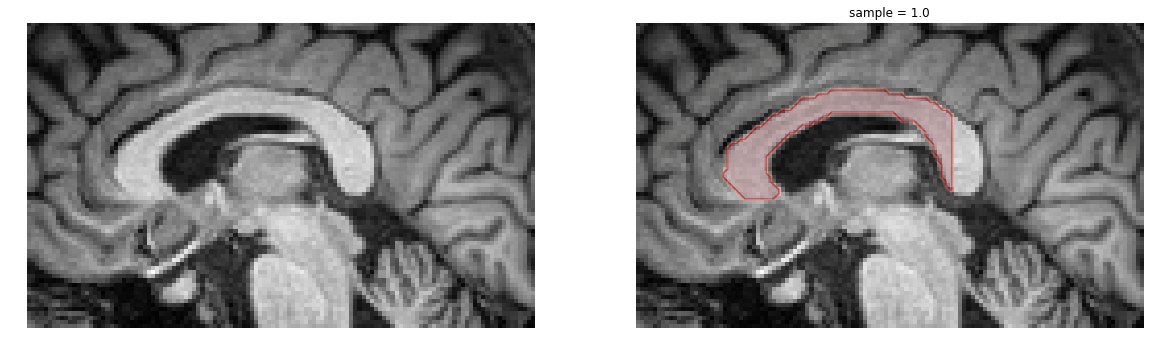

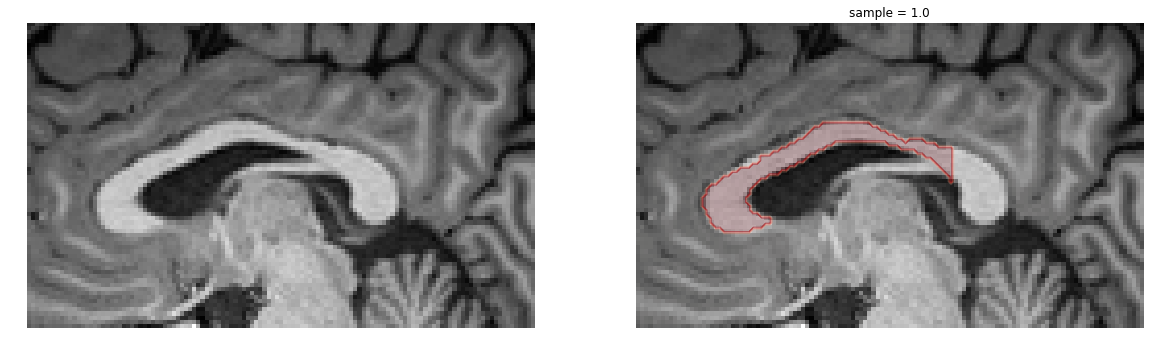

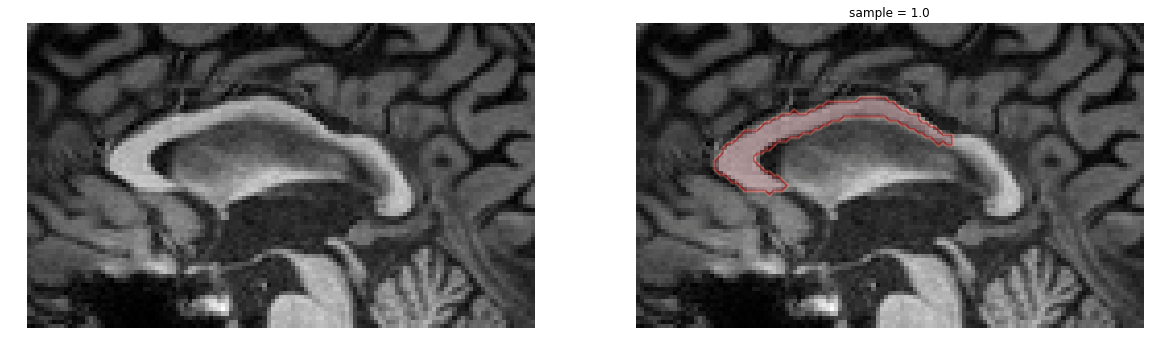

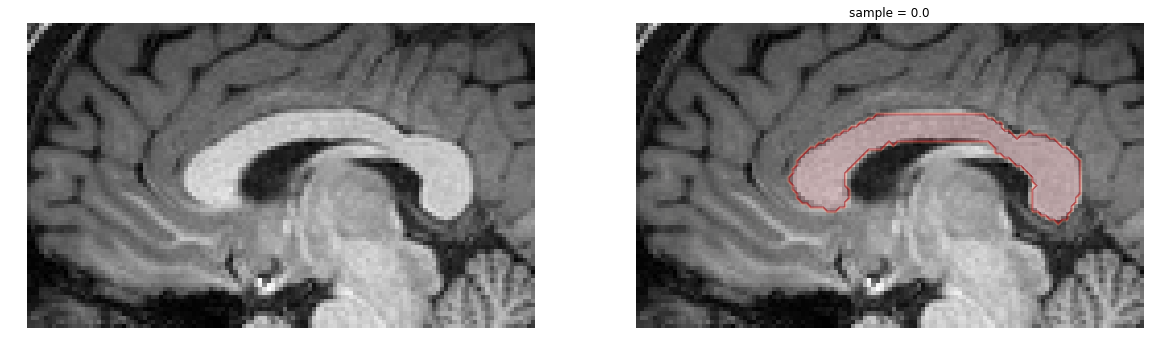

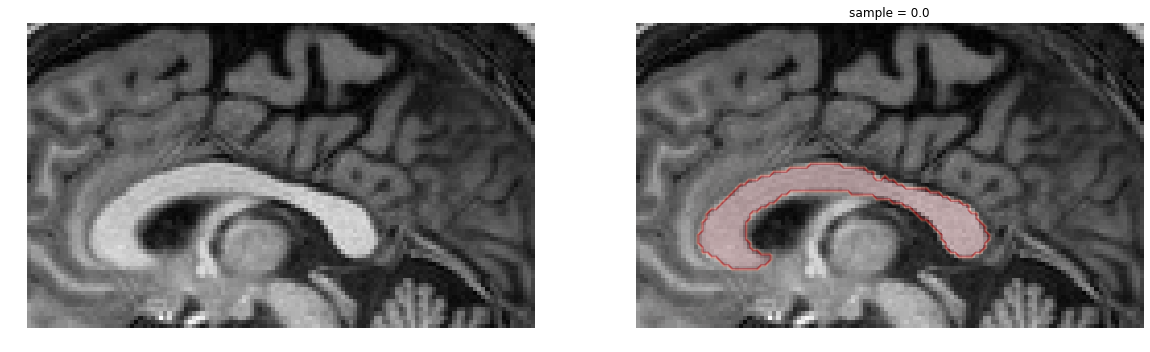

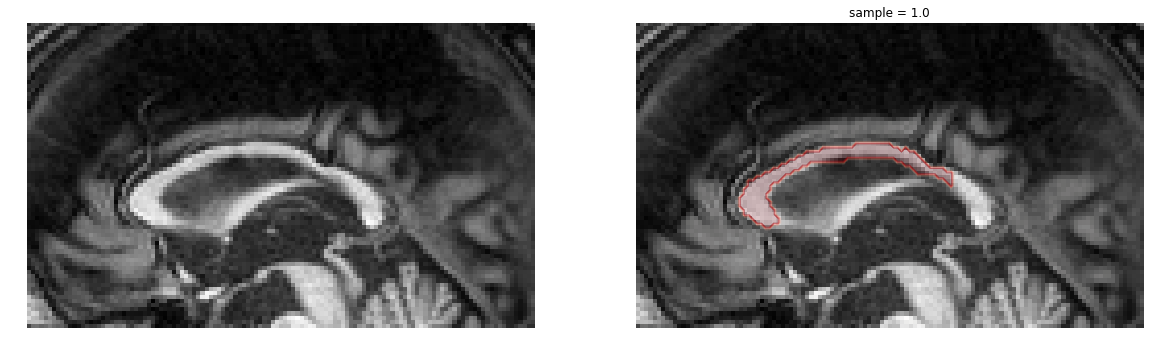

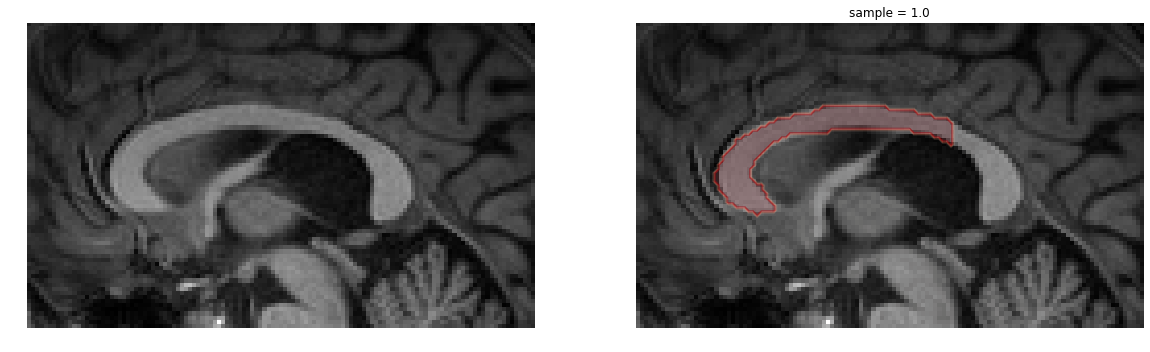

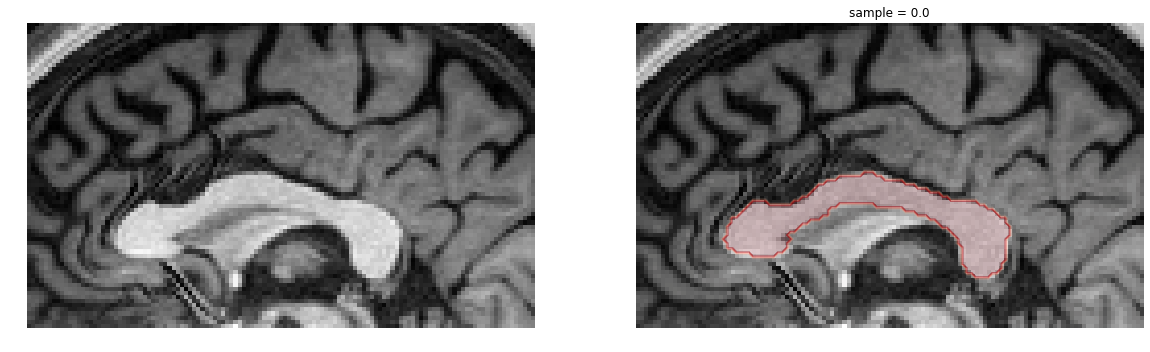

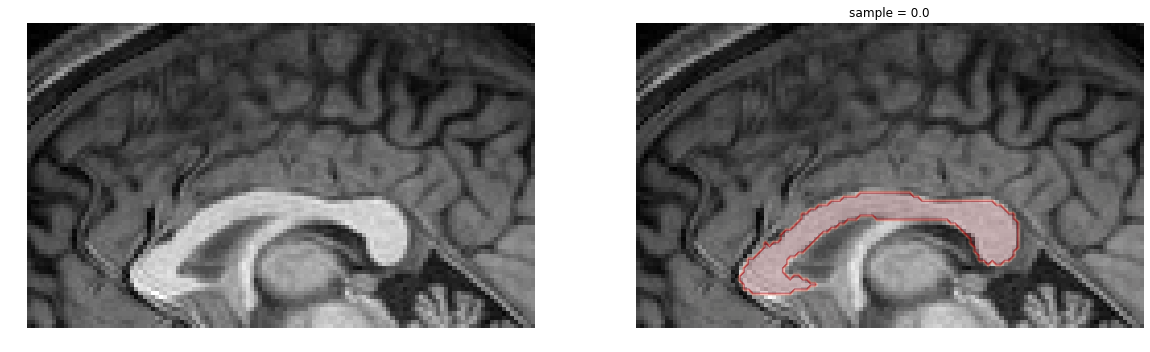

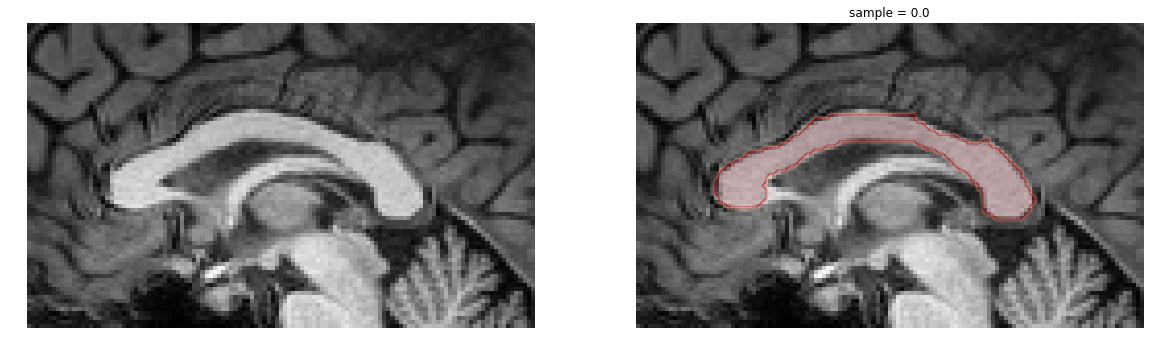

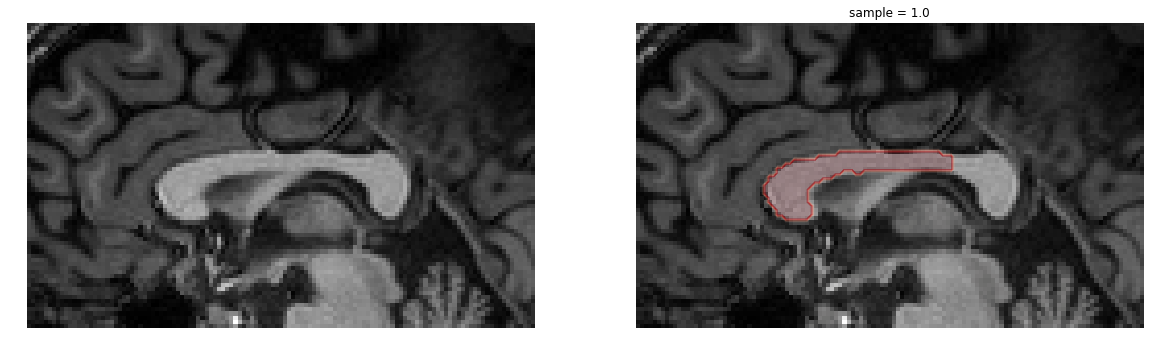

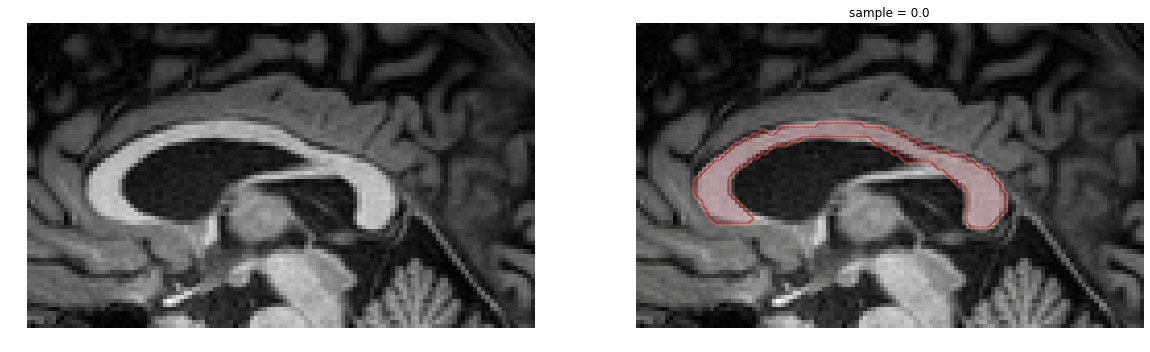

====== Test Dataloader ======


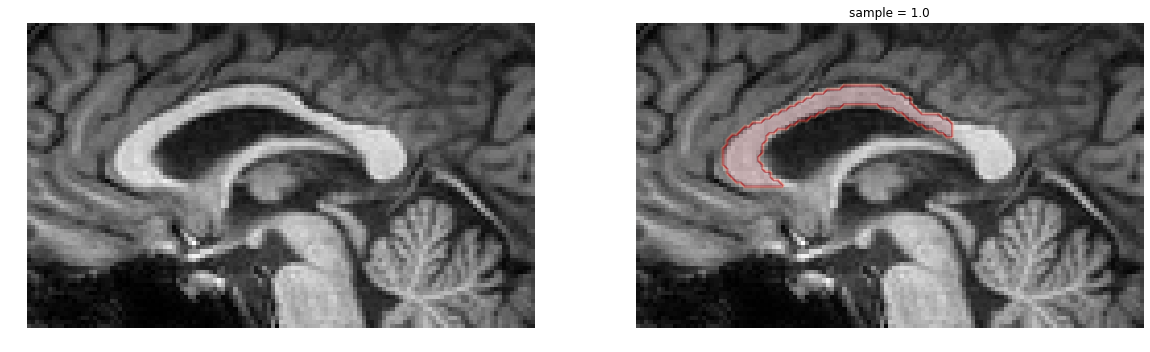

In [16]:
mycmap = transparent_cmap(plt.cm.Reds)
print('New dataset size (Leaving out sized-different subjects): ', n_samples)
print('====== Train Dataloader ======')
for i_batch, sample_batched in enumerate(train_loader):
    image, label = sample_batched['image'], sample_batched['label']
    random_index = random.randint(0, image.size()[0]-1)
    plot_img_mask(image[random_index], label[random_index])
    #if i_batch == 2:
    #    break
print('====== Test Dataloader ======')
for i_batch, sample_batched in enumerate(test_loader):
    image, label = sample_batched['image'], sample_batched['label']
    random_index = random.randint(0, image.size()[0]-1)
    plot_img_mask(image[random_index], label[random_index])

## CNN

In [18]:
__all__ = ['ResNet', 'resnet10', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnet200']

def conv3x3x3(in_planes, out_planes, stride=1):
    # 3x3x3 convolution with padding
    return nn.Conv3d(in_planes, out_planes, kernel_size=3,
                     stride=stride, padding=1, bias=False)

def downsample_basic_block(x, planes, stride):
    out = F.avg_pool3d(x, kernel_size=1, stride=stride)
    zero_pads = torch.Tensor(out.size(0), planes - out.size(1),
                             out.size(2), out.size(3),
                             out.size(4)).zero_()
    if isinstance(out.data, torch.cuda.FloatTensor):
        zero_pads = zero_pads.cuda()

    out = Variable(torch.cat([out.data, zero_pads], dim=1))

    return out

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = nn.Conv3d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = nn.Conv3d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, sample_size, sample_duration, shortcut_type='B', num_classes=400, last_fc=True):
        self.last_fc = last_fc

        self.inplanes = 64
        super(ResNet, self).__init__()
        #self.conv1 = nn.Conv3d(3, 64, kernel_size=7, stride=(1, 2, 2),
        self.conv1 = nn.Conv3d(2, 64, kernel_size=7, stride=(1, 2, 2),
                               padding=(3, 3, 3), bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], shortcut_type)
        self.layer2 = self._make_layer(block, 128, layers[1], shortcut_type, stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], shortcut_type, stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], shortcut_type, stride=2)
        last_duration = math.ceil(sample_duration / 16)
        last_size = math.ceil(sample_size / 32)
        self.avgpool = nn.AvgPool3d((last_duration, last_size, last_size), stride=1)
        self.fc1 = nn.Linear(6144 * block.expansion, 1024)
        self.dropout = nn.Dropout3d(0.6)
        self.fc2 = nn.Linear(1024, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(downsample_basic_block,
                                     planes=planes * block.expansion,
                                     stride=stride)
            else:
                downsample = nn.Sequential(
                    nn.Conv3d(self.inplanes, planes * block.expansion,
                              kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm3d(planes * block.expansion)
                )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        if self.last_fc:
            x = self.dropout(self.fc1(x))
            x = self.fc2(x)

        return x

def get_fine_tuning_parameters(model, ft_begin_index):
    if ft_begin_index == 0:
        return model.parameters()

    ft_module_names = []
    for i in range(ft_begin_index, 5):
        ft_module_names.append('layer{}'.format(ft_begin_index))
    ft_module_names.append('fc')

    parameters = []
    for k, v in model.named_parameters():
        for ft_module in ft_module_names:
            if ft_module in k:
                parameters.append({'params': v})
                break
        else:
            parameters.append({'params': v, 'lr': 0.0})

    return parameters

def resnet10(**kwargs):
    """Constructs a ResNet-10 model.
    """
    model = ResNet(BasicBlock, [1, 1, 1, 1], **kwargs)
    return model

def resnet18(**kwargs):
    """Constructs a ResNet-18 model.
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model

def resnet34(**kwargs):
    """Constructs a ResNet-34 model.
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    return model

def resnet50(**kwargs):
    """Constructs a ResNet-50 model.
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model

def resnet101(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    return model

def resnet152(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    return model

def resnet200(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = ResNet(Bottleneck, [3, 24, 36, 3], **kwargs)
    return model

In [19]:
net = resnet18(sample_size = 56, sample_duration = 32, num_classes=2)
net = net.double()
net.to(device)
print(net)

ResNet(
  (conv1): Conv3d(2, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [20]:
def calculate_accuracy(outputs, targets):

    _, pred = outputs.topk(1, 1, True)
    equality = pred == targets.view(*pred.shape)

    return torch.mean(equality.type(torch.FloatTensor)).item()

def train_epoch(epochs, tr_loader, vl_loader, model, criterion, optimizer,
                tr_loss_ep = AverageMeter(), vl_loss_ep = AverageMeter()):
    
    print('Training for {} epochs'.format(epochs))
    epoch_time = AverageMeter()
    
    for epoch in range(epochs):
    
        tr_loss, tr_accuracy = AverageMeter(), AverageMeter()
        vl_loss, vl_accuracy = AverageMeter(), AverageMeter()
        tr_accuracy, vl_accuracy = AverageMeter(), AverageMeter()

        end_time = time.time()
        for i, sample_batched in enumerate(tr_loader):
            inputs = sample_batched['image'].to(device)
            targets = sample_batched['label'].type(torch.LongTensor).to(device)
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            acc = calculate_accuracy(outputs, targets)
            tr_loss.update(loss.item(), inputs.size(0))
            tr_accuracy.update(acc, inputs.size(0))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                model.eval()

                for i, sample_batched in enumerate(vl_loader):
                    inputs = sample_batched['image'].to(device)
                    targets = sample_batched['label'].type(torch.LongTensor).to(device)
            
                    inputs, targets = Variable(inputs), Variable(targets)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    acc = calculate_accuracy(outputs, targets)
                    vl_loss.update(loss.item(), inputs.size(0))
                    vl_accuracy.update(acc, inputs.size(0))
                tr_loss_ep.update(tr_loss.avg)
                vl_loss_ep.update(vl_loss.avg)

                epoch_time.update(time.time() - end_time)
                end_time = time.time()

                model.train()

                print('Epoch: [{0}/{1}]\t'
                      'Time: {2:.3f}\t'
                      'Loss: [train>{3:.3f}/val>{4:.3f}]\t'
                      'Acc {5:.3f}'.format(
                          epoch+1, epochs, epoch_time.val, tr_loss.avg, vl_loss.avg, vl_accuracy.avg))
                
    
    print('Total train for {0} epochs, Total time: {1:.3f}'.format(epoch+1, epoch_time.sum))
    return tr_loss_ep, vl_loss_ep

def test(data_loader, model):
    print('Testing...')

    model.eval()

    data_time = AverageMeter()

    end_time = time.time()
    for i, sample_batched in enumerate(data_loader):
        inputs = sample_batched['image'].to(device)
        targets = sample_batched['label'].type(torch.LongTensor).to(device)
        inputs = Variable(inputs)
        
        with torch.no_grad():
            outputs = model(inputs)
        
        _, predicted = outputs.topk(1, 1, True)
        print('Predict: ',predicted.view(1,-1))
        print('Targets: ',targets)
        
        test_acc = calculate_accuracy(outputs, targets)
        
        data_time.update(time.time() - end_time)
        end_time = time.time()

        print('Time: {0:.3f}\t'
              'Acc {1:.3f}'.format(data_time.val, test_acc))
        
        return predicted.cpu().numpy().squeeze()

In [21]:
epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.003)
tr_loss, vl_loss = train_epoch(epochs, train_loader, test_loader, net, criterion, optimizer)

Training for 30 epochs
Epoch: [1/30]	Time: 99.244	Loss: [train>15.066/val>146.136]	Acc 0.500
Epoch: [2/30]	Time: 103.354	Loss: [train>6.003/val>42.919]	Acc 0.667
Epoch: [3/30]	Time: 102.298	Loss: [train>5.502/val>4.320]	Acc 0.583
Epoch: [4/30]	Time: 102.707	Loss: [train>1.837/val>0.860]	Acc 0.500
Epoch: [5/30]	Time: 102.932	Loss: [train>1.208/val>0.704]	Acc 0.500
Epoch: [6/30]	Time: 102.033	Loss: [train>0.942/val>0.704]	Acc 0.500
Epoch: [7/30]	Time: 102.040	Loss: [train>0.975/val>0.582]	Acc 0.500
Epoch: [8/30]	Time: 101.983	Loss: [train>0.921/val>0.713]	Acc 0.500
Epoch: [9/30]	Time: 102.683	Loss: [train>0.762/val>0.602]	Acc 0.667
Epoch: [10/30]	Time: 102.425	Loss: [train>0.703/val>0.709]	Acc 0.667
Epoch: [11/30]	Time: 101.958	Loss: [train>0.704/val>0.632]	Acc 0.667
Epoch: [12/30]	Time: 101.885	Loss: [train>0.665/val>0.638]	Acc 0.583
Epoch: [13/30]	Time: 101.412	Loss: [train>0.678/val>0.660]	Acc 0.667
Epoch: [14/30]	Time: 101.544	Loss: [train>0.670/val>0.652]	Acc 0.667
Epoch: [15/30]	Ti

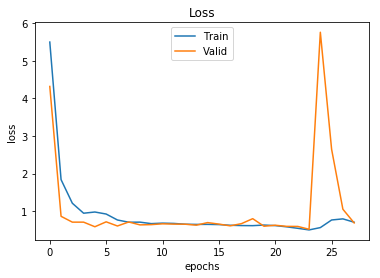

In [23]:
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(tr_loss.vc[2:], label='Train')
plt.plot(vl_loss.vc[2:], label='Valid')
plt.legend()
plt.show()

Testing...
Predict:  tensor([[0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]], device='cuda:0')
Targets:  tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Time: 7.842	Acc 0.583


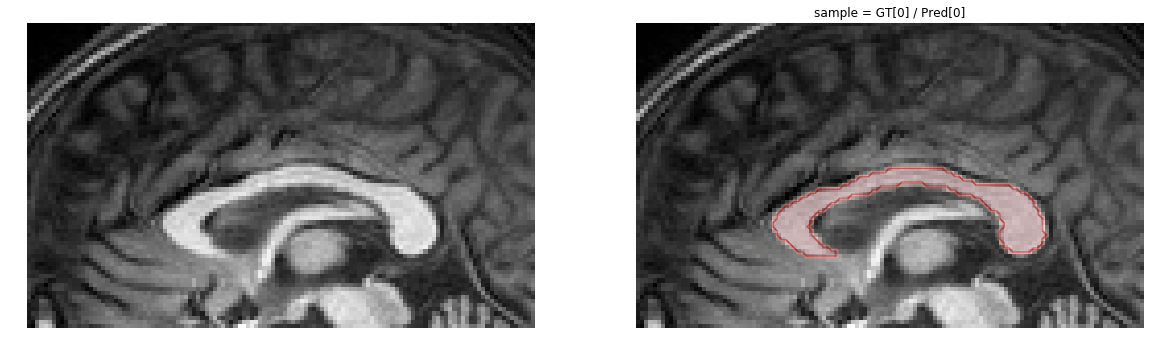

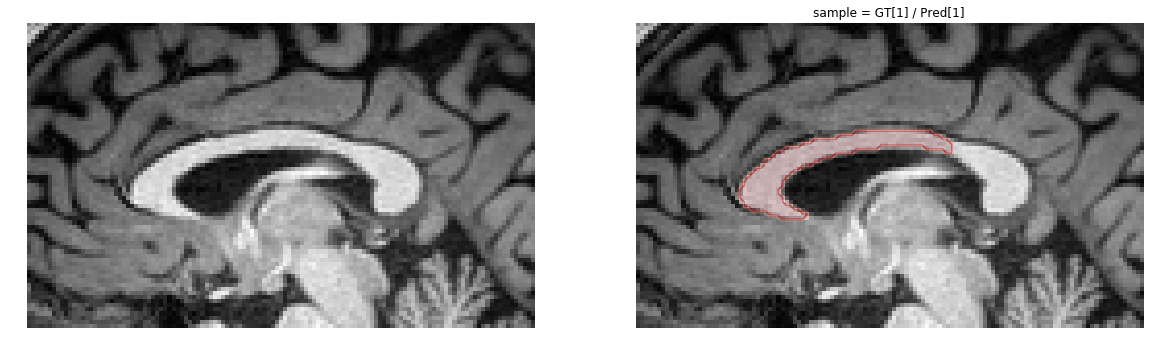

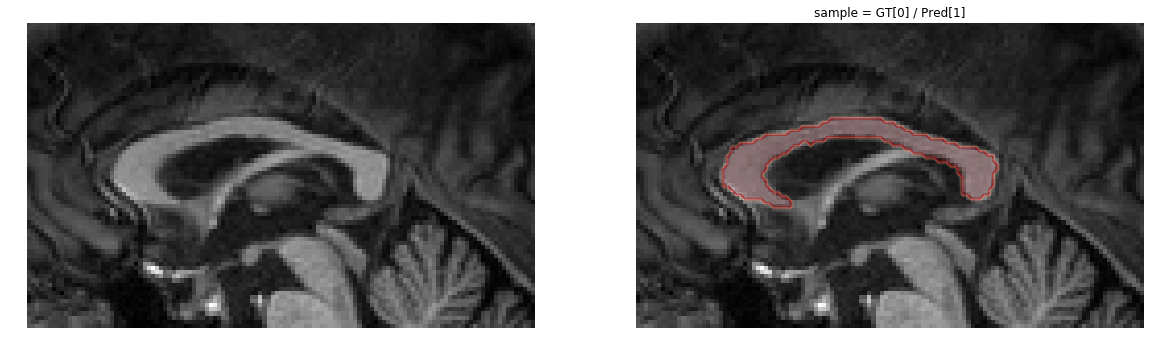

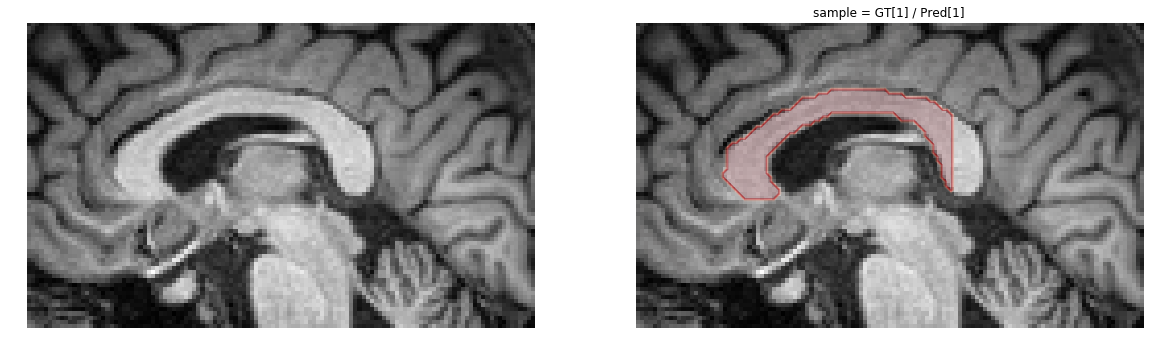

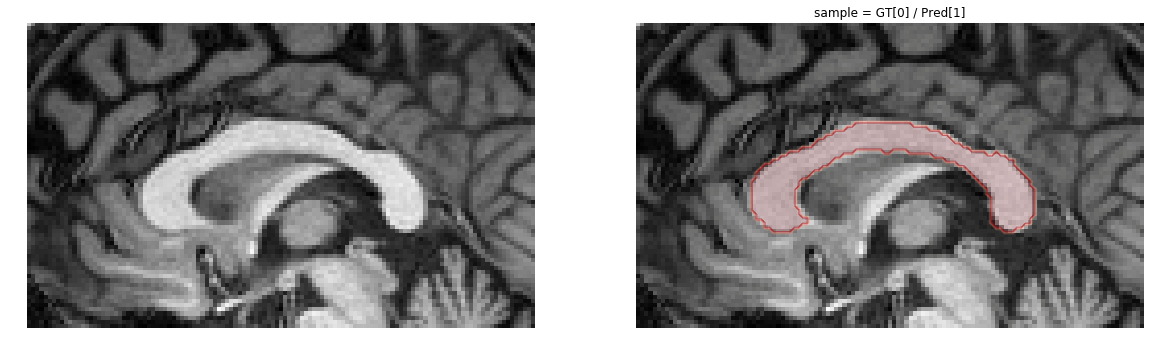

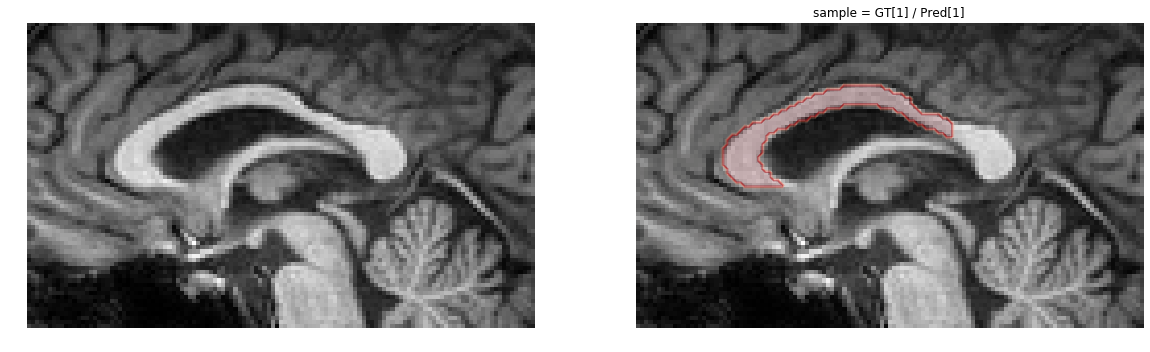

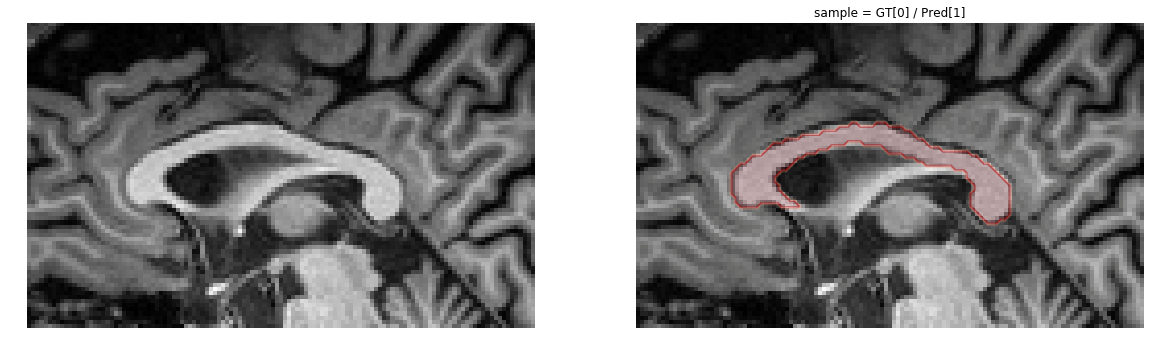

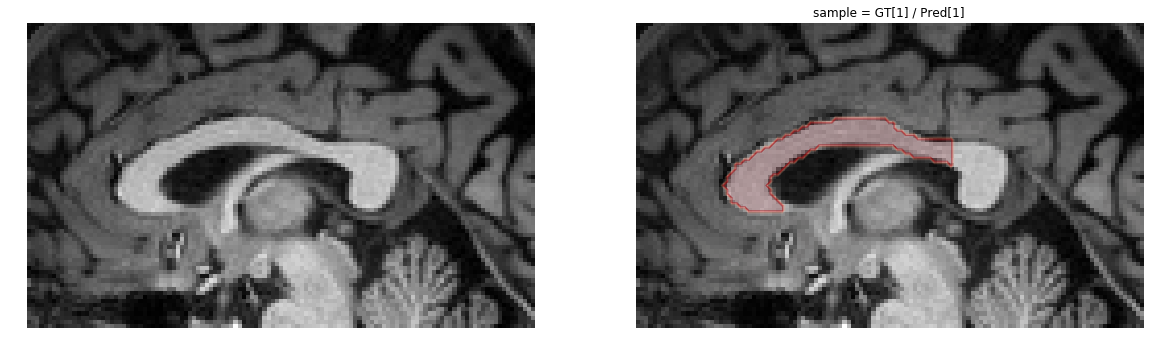

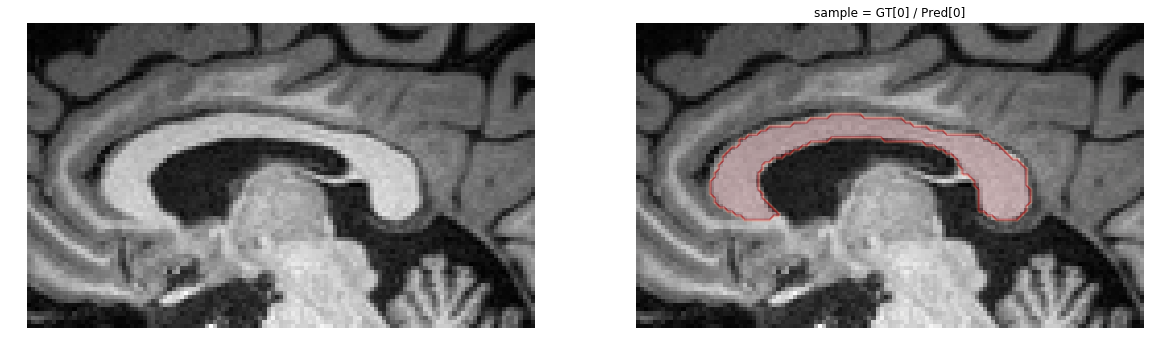

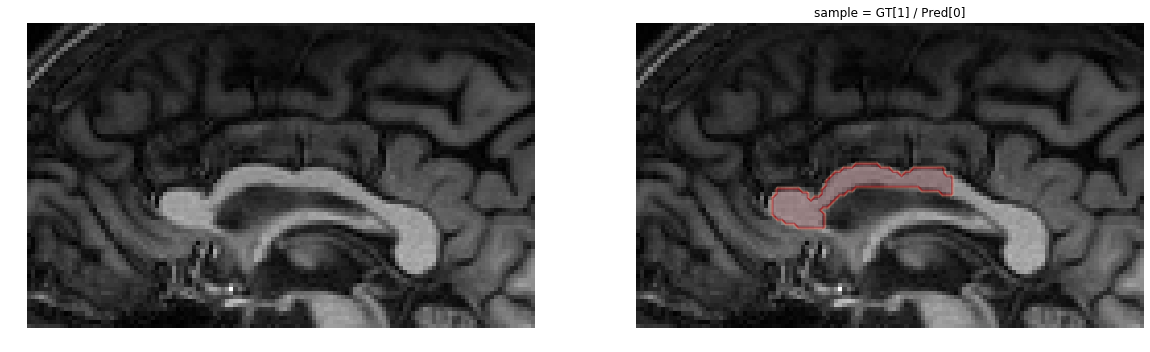

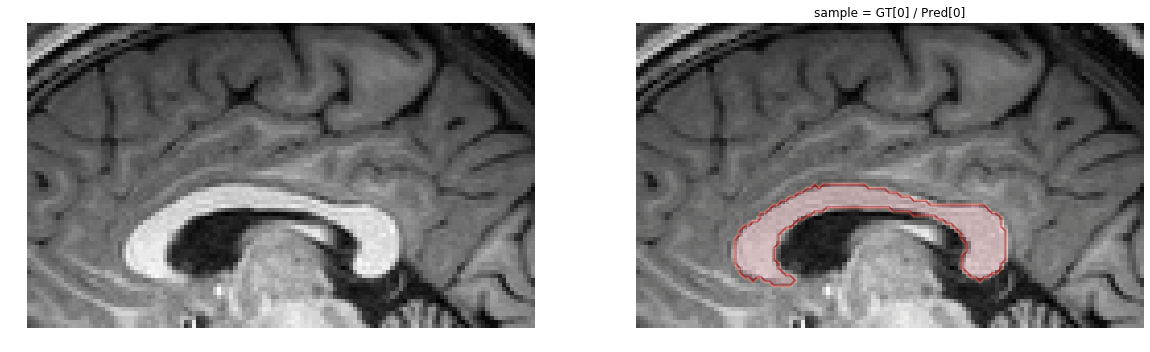

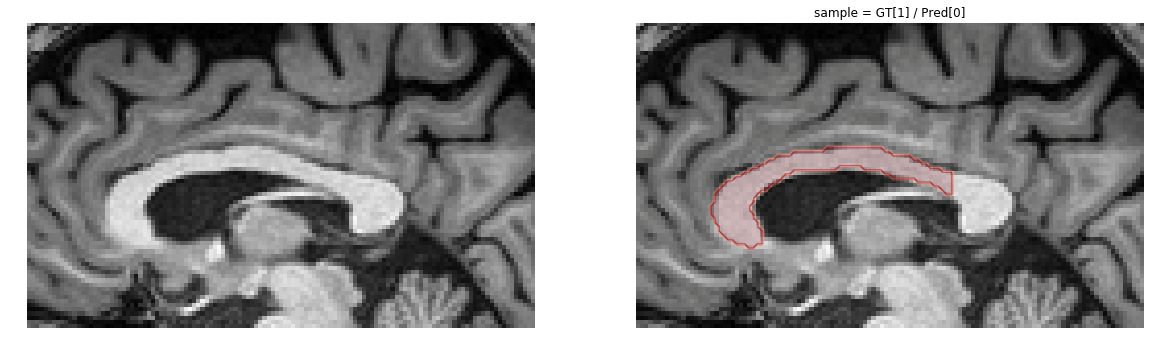

In [24]:
predicted = test(test_loader, net)
for i_batch, sample_batched in enumerate(test_loader):
    image, label = sample_batched['image'], sample_batched['label']
    for elem in range(image.size(0)):
        plot_img_mask(image[elem], int(label[elem]), predicted[elem])